## Recap:
We now have a labeled dataset with imgs. Now it's time to build a clickbait model that only uses the image as an input.

Since we are smart, building it from scratch is not a good idea (We already tried in Clickbait 1.0, let's not make the same mistake). Instead we will use one of Google's pretrained models and use Transfer Learning.

We basically have to choose between Inception vs. ResNet  (Speed vs. Accuracy)

I'll used Inception model, since it was trained on millions of images and already has a bunch of pretrained layers.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub

np.random.seed(179)
print(tf.__version__) # 2.x required

2.1.0


In [2]:
df = pd.read_pickle("labeled_clickbait.pkl")

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


pre_trained_model = InceptionV3(input_shape=(90, 120, 3),
                                weights=None, 
                                include_top=False)

pre_trained_model.load_weights('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [13]:
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 90, 120, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 44, 59, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 44, 59, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 44, 59, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [114]:
last_layer = pre_trained_model.get_layer('mixed7') #'mixed2')

last_output = last_layer.output

In [115]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation="sigmoid")(x)

In [116]:
model = tf.keras.Model( pre_trained_model.input, x)
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["acc", tf.keras.metrics.AUC()])

In [117]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 90, 120, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 44, 59, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 44, 59, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 44, 59, 32)   0           batch_normalization_94[0][0]     
___________________________________________________________________________________________

In [118]:
def generate_traintest(df, SPLIT_RATIO=0.8):
    shuffled_df = df.sample(frac=1).reset_index(drop=True)[['image', 'clickbait']]
    n = shuffled_df.shape[0]
    train_imgs = np.array(list(shuffled_df['image'][:int(n * SPLIT_RATIO)]))
    train_labels = np.array(list(shuffled_df['clickbait'][:int(n * SPLIT_RATIO)]))
    #train_imgs = shuffled_df['image'][:int(n * SPLIT_RATIO)].values
    #train_labels = shuffled_df['clickbait'][:int(n * SPLIT_RATIO)].values
    
    test_imgs = np.array(list(shuffled_df['image'][int(n * SPLIT_RATIO):]))
    test_labels = np.array(list(shuffled_df['clickbait'][int(n * SPLIT_RATIO):]))
    #test_imgs = shuffled_df['image'][int(n * SPLIT_RATIO):].values
    #test_labels = shuffled_df['clickbait'][int(n * SPLIT_RATIO):].values
    
    return (train_imgs, train_labels), (test_imgs, test_labels)


(train_imgs, train_labels), (test_imgs, test_labels) = generate_traintest(df)

print(train_imgs.shape, train_labels.shape, sum(train_labels==True))

(4749, 90, 120, 3) (4749,) 3094


In [119]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 10

train_datagen = ImageDataGenerator(rescale= 1/255.)
train_generator = train_datagen.flow(train_imgs, train_labels, batch_size=BATCH_SIZE)


In [120]:
history = model.fit(train_generator, 
          steps_per_epoch=train_imgs.shape[0] / BATCH_SIZE,
         epochs = 5,
         validation_data=(test_imgs, test_labels))

  ...
    to  
  ['...']
Train for 474.9 steps, validate on 1188 samples
Epoch 1/5
475/474 [==============================] - 59s 124ms/step - loss: 0.6565 - acc: 0.6465 - auc_9: 0.5679 - val_loss: 18.1569 - val_acc: 0.6692 - val_auc_9: 0.5007- ETA: 0s - loss: 0.6564 - acc: 0.6466 - auc_9: 0.5
Epoch 2/5
475/474 [==============================] - 56s 118ms/step - loss: 0.5793 - acc: 0.6993 - auc_9: 0.7218 - val_loss: 22.4261 - val_acc: 0.6684 - val_auc_9: 0.5168
Epoch 3/5
475/474 [==============================] - 56s 119ms/step - loss: 0.3920 - acc: 0.8290 - auc_9: 0.8932 - val_loss: 98.7903 - val_acc: 0.6700 - val_auc_9: 0.5083
Epoch 4/5
475/474 [==============================] - 68s 143ms/step - loss: 0.1745 - acc: 0.9366 - auc_9: 0.9836 - val_loss: 161.6355 - val_acc: 0.6692 - val_auc_9: 0.5026
Epoch 5/5
475/474 [==============================] - 70s 147ms/step - loss: 0.0541 - acc: 0.9899 - auc_9: 0.9994 - val_loss: 265.7674 - val_acc: 0.6709 - val_auc_9: 0.5025


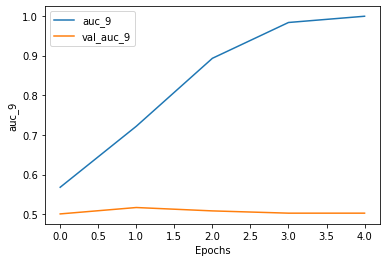

In [122]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
    
plot_graphs(history, "auc_9")